# Mount to Collab:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Imports:

In [2]:
# Utilities
!pip install sentinelhub
!pip install speedtest-cli # Install speedtest-cli
!pip install termcolor
!pip install geopandas
!pip install xarray
!pip install cartopy

try:
    import speedtest # Import the speedtest module to check internet speed
    import os
    import pickle # to export attributes dictionary from harpconversion.py to the main collab notebook
    import datetime # for making the folder based on the dates
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import requests
    import geopandas # to handle gdf
    from datetime import datetime # for date parameter
    from termcolor import colored # to have colored text
    from multiprocessing.pool import ThreadPool # for downloading Products in parallel
    from functools import partial # for downloading Products in parallel
    import multiprocessing # to check the number of cores in collab
    import zipfile # to extract zip files
    from glob import iglob # data access in file manager
    from os.path import join # same
    from tqdm import tqdm
    import xarray as xr
    import cartopy # improved visualizations
    import cartopy.crs as ccrs # Projected visualizations
    import cartopy.feature as cf
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    import matplotlib.patches as mpatches
    from datetime import timedelta
    import time
    import re


    from sentinelhub import (SHConfig, DataCollection, SentinelHubCatalog, SentinelHubRequest, BBox, bbox_to_dimensions, CRS, MimeType, Geometry)
except ModuleNotFoundError as e:
    print(colored(f'Module import error: {e.name} not found', 'red'))
else:
    print(colored('\nAll libraries properly loaded. Ready to start!!!', 'green'), '\n')


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.9 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=fcbe29661dd09d99200f8c73c399772552168b6316928ba6175747acbc62037b
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 77.9 MB/s eta 0:00:00

All libraries properly loaded. Ready to start!!! 



# Downloading L2 S5P data

First we Enter the Search Details:

In [3]:
import sys
sys.path.append('/content')
from init import (
    username,
    password,
    L2_Files,
    L3_Files,
    Base_Merged_Files,
    Base_Final_Files,
    Base_PBLH_T2M_Files,
    start_date,
    end_date,
    pollutant,
    data_collection,
    aoi_file_path,
    aoi_name_to_display,
    qa,
    unit,
    num_threads,
    num_workers
)
from utils import (
    load_geojson,
    extract_aoi,
    analyze_pollutants,
    move_nc_files_and_cleanup,
    compute_lengths_and_offsets,
    get_user_choice_to_filter_data,
    filter_data,
    count_pollutant_data_types,
    get_keycloak,
    refresh_access_token,
    is_refresh_token_expired,
    is_access_token_expired,
    get_regex_pattern,
    get_variables_to_include


)

Enter start date (YYYY-MM-DD): 2022-08-29
Enter end date (YYYY-MM-DD): 2022-12-31
Start date: 2022-08-29
End date: 2022-12-31
Please select a pollutant by entering the corresponding number:
1. Ozone (O3) total column (L2__O3____)
2. Nitrogen Dioxide (NO2), tropospheric, stratospheric, slant column (L2__NO2___)
3. Sulfur Dioxide (SO2) total column (L2__SO2___)
4. Carbon Monoxide (CO) total column (L2__CO____)
5. Methane (CH4) total column (L2__CH4___)
6. Formaldehyde (HCHO) tropospheric, slant column (L2__HCHO__)
7. UV Aerosol Index (L2__AER_AI)
8. Cloud fraction, albedo, top pressure (L2__CLOUD_)
Enter your choice (1-8): 3
Enter QA value (0-100): 50
QA value: 50
Chosen Values:
-----------------------------------------------------------------------------------------------
|Title                         |Value                                                       |
-----------------------------------------------------------------------------------------------
|Start Date                 

These are all the collections available:

In [4]:
print(colored("These are all the available collections:"),'green')
for collection in DataCollection.get_available_collections():
    print(collection)

These are all the available collections: green
DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL


The collection we need is as follows:

In [5]:
print(colored("The collection we need is as follows:"),'green')
DataCollection.SENTINEL5P

The collection we need is as follows: green


<DataCollection.SENTINEL5P: DataCollectionDefinition(
  api_id: sentinel-5p-l2
  catalog_id: sentinel-5p-l2
  wfs_id: DSS7
  service_url: https://creodias.sentinel-hub.com
  collection_type: Sentinel-5P
  sensor_type: TROPOMI
  processing_level: L2
  bands: (Band(name='CO', units=(<Unit.DN: 'DN'>,), output_types=(<class 'numpy.float32'>,)), Band(name='HCHO', units=(<Unit.DN: 'DN'>,), output_types=(<class 'numpy.float32'>,)), Band(name='NO2', units=(<Unit.DN: 'DN'>,), output_types=(<class 'numpy.float32'>,)), Band(name='O3', units=(<Unit.DN: 'DN'>,), output_types=(<class 'numpy.float32'>,)), Band(name='SO2', units=(<Unit.DN: 'DN'>,), output_types=(<class 'numpy.float32'>,)), Band(name='CH4', units=(<Unit.PPB: 'PPB'>,), output_types=(<class 'numpy.float32'>,)), Band(name='AER_AI_340_380', units=(<Unit.INDEX: 'INDEX'>,), output_types=(<class 'numpy.float32'>,)), Band(name='AER_AI_354_388', units=(<Unit.INDEX: 'INDEX'>,), output_types=(<class 'numpy.float32'>,)), Band(name='CLOUD_BASE_PRES

We can extract AOI form a geojson file using this code
(which handles polygon and multipolygon geometries):

In [6]:
# aoi_file_path is the actual path to your GeoJSON file
geojson_path = aoi_file_path
geojson_data = load_geojson(geojson_path)

if geojson_data:
    aoi_wkt = extract_aoi(geojson_data)
    if aoi_wkt:
        # Use the extracted AOI WKT string in your code
        # For example, replacing a manual AOI string in an API request
        aoi = aoi_wkt
        print("Extracting AOI")
    else:
        print("Failed to extract AOI.")
else:
    print("Failed to load GeoJSON data.")

# In order to make the AOI format readable by the API we tweak the AOI a bit
aoi=aoi + "'"
aoi

Extracting AOI


"POLYGON ((80.27089867031938 13.047525928518052, 80.27062167407598 13.047591755375635, 80.27050695715906 13.045203190846609, 80.27053395395347 13.044290918151525, 80.27038041111325 13.044212330044015, 80.27005142173557 13.044365637419821, 80.26688687128348 13.044754074049104, 80.26339793167058 13.044752266604966, 80.26329361790859 13.043412097108286, 80.26316197876544 13.043023025410394, 80.2631450038722 13.042751132448235, 80.2632048003989 13.042518533539742, 80.26351500765513 13.042306871271023, 80.26403740422437 13.042077086063824, 80.26454233301988 13.04163364554944, 80.2660466427371 13.039094954828416, 80.26564806288553 13.039352031941839, 80.26501080813235 13.03970746558702, 80.26392058392422 13.039720796095997, 80.26269247006773 13.039633479671355, 80.26150669749556 13.03922703441792, 80.26079422036065 13.039102930987218, 80.26018185275151 13.038859666572678, 80.25909281106674 13.038733272739842, 80.25732704518694 13.038942110836999, 80.25812949593298 13.040144690497865, 80.2585

Now we make the pollutant search:


In [7]:
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = datetime.strptime(end_date, '%Y-%m-%d')

# Initialize an empty list to store results dataframes
all_results = []

# Iterate through each day in the date range
current_date = start_date
while current_date <= end_date:
    # Construct the date string in the required format
    current_date_str = current_date.strftime('%Y-%m-%d')

    # Construct the query URL for the current date
    query_url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq '{data_collection}' and contains(Name,'{pollutant}') and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}) and ContentDate/Start ge {current_date_str}T00:00:00.000Z and ContentDate/Start lt {current_date_str}T23:59:59.999Z"

    # Make the request for the current date
    json = requests.get(query_url).json()

    # Check if there are any results for the current date
    if 'value' in json:
        # Convert the results to a dataframe and append to the list
        results_df = pd.DataFrame.from_dict(json['value'])
        all_results.append(results_df)

    # Move to the next day
    current_date += timedelta(days=1)

# Concatenate all dataframes in the list into a single dataframe
results = pd.concat(all_results, ignore_index=True)

# Output the final dataframe
results

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,f350c7db-0cf6-5758-b81c-20b244eb26df,S5P_NRTI_L2__SO2____20220829T083218_20220829T0...,application/octet-stream,0,2022-08-29T09:25:04.260000Z,2022-08-29T09:31:53.190221Z,2022-08-29T09:31:53.190221Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/08...,[],"{'Start': '2022-08-29T08:32:12.000000Z', 'End'...",geography'SRID=4326;POLYGON ((55.501698 24.738...,"{'type': 'Polygon', 'coordinates': [[[55.50169..."
1,application/octet-stream,5d90f359-de86-4929-b567-e0037518c0f9,S5P_RPRO_L2__SO2____20220829T074104_20220829T0...,application/octet-stream,1070713336,2024-07-30T15:04:12.641000Z,2024-07-30T15:10:28.496196Z,2024-07-30T15:10:52.771483Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/08...,"[{'Value': 'fcaf015646ea51e4a29f2b15caf3333c',...","{'Start': '2022-08-29T08:03:37.000000Z', 'End'...",geography'SRID=4326;POLYGON ((-74.27165 56.599...,"{'type': 'Polygon', 'coordinates': [[[-74.2716..."
2,application/octet-stream,cb982e08-c43f-5b04-bee0-81297e97e985,S5P_NRTI_L2__SO2____20220830T081218_20220830T0...,application/octet-stream,0,2022-08-30T09:05:03.832000Z,2022-08-31T06:21:59.211607Z,2022-08-31T06:21:59.211607Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/08...,[],"{'Start': '2022-08-30T08:12:12.000000Z', 'End'...",geography'SRID=4326;POLYGON ((61.4706 21.46131...,"{'type': 'Polygon', 'coordinates': [[[61.4706,..."
3,application/octet-stream,fe94811e-b850-529e-bcc6-eac208cdba92,S5P_OFFL_L2__SO2____20220830T072255_20220830T0...,application/octet-stream,0,2022-09-02T07:09:01.296000Z,2022-09-02T07:28:14.292046Z,2022-09-02T07:28:14.292046Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/08...,[],"{'Start': '2022-08-30T07:44:30.000000Z', 'End'...","geography'SRID=4326;MULTIPOLYGON (((180 -90, 0...","{'type': 'MultiPolygon', 'coordinates': [[[[18..."
4,application/octet-stream,9e5fdc7e-8cfc-5ec3-98d8-7a1e3da3e35f,S5P_NRTI_L2__SO2____20220831T075245_20220831T0...,application/octet-stream,0,2022-08-31T08:50:03.262000Z,2022-08-31T09:01:22.155185Z,2022-08-31T09:01:22.155185Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/08...,[],"{'Start': '2022-08-31T07:52:40.000000Z', 'End'...",geography'SRID=4326;POLYGON ((66.850334 19.670...,"{'type': 'Polygon', 'coordinates': [[[66.85033..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,application/octet-stream,59abe8fd-bc4f-52d8-9cb9-7351c28998b9,S5P_OFFL_L2__SO2____20221229T074618_20221229T0...,application/octet-stream,1020129264,2023-01-01T19:52:53.282129Z,2023-01-01T20:55:54.963043Z,2023-01-01T20:55:57.817856Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/12...,[{}],"{'Start': '2022-12-29T08:07:52.000000Z', 'End'...",geography'SRID=4326;POLYGON ((34.083866 52.595...,"{'type': 'Polygon', 'coordinates': [[[34.08386..."
248,application/octet-stream,47b6cbd6-83e6-593a-b0db-4dbb9979cc6d,S5P_NRTI_L2__SO2____20221230T082405_20221230T0...,application/octet-stream,113975273,2022-12-30T08:21:49.076437Z,2022-12-30T09:27:10.147554Z,2022-12-30T09:27:13.322186Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/12...,[{}],"{'Start': '2022-12-30T08:23:59.000000Z', 'End'...",geography'SRID=4326;POLYGON ((60.716335 13.490...,"{'type': 'Polygon', 'coordinates': [[[60.71633..."
249,application/octet-stream,bc78133d-151c-5201-a1e7-a70eac44d199,S5P_OFFL_L2__SO2____20221230T072718_20221230T0...,application/octet-stream,1055952087,2023-01-02T10:43:13.326693Z,2023-01-02T11:46:44.136927Z,2023-01-02T11:46:46.760370Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/12...,[{}],"{'Start': '2022-12-30T07:48:53.000000Z', 'End'...",geography'SRID=4326;POLYGON ((4.6380954 67.041

We can also filter the pollutant based on its type e.g (Offline, Real-time, Reprocessed)

In [8]:
# Call the function and get counts and total
offline_count, nrti_count, rpro_count, total_count = count_pollutant_data_types(results)

# Print the counts and total
print(f"Total number of entries: {total_count}")
print(f"Number of Offline data entries: {offline_count}")
print(f"Number of Near Real-Time data entries: {nrti_count}")
print(f"Number of Reprocessed data entries: {rpro_count}")

Total number of entries: 252
Number of Offline data entries: 124
Number of Near Real-Time data entries: 127
Number of Reprocessed data entries: 1


In [9]:
# Get a valid user choice and the corresponding base_type
user_choice, base_type = get_user_choice_to_filter_data()

# Display the selected base_type
print(f"Base type selected: {base_type}")

# Filter the DataFrame based on the user's choice
results = filter_data(results, user_choice)

# Output or further process the filtered DataFrame
results


Select the type of data you wish to keep:
1: Keep all results
2: Keep only the offline data
3: Keep only the near real time data
4: Keep only the reprocessed data
Enter your choice (1/2/3/4): 2
Base type selected: OFFL


,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
3,application/octet-stream,fe94811e-b850-529e-bcc6-eac208cdba92,S5P_OFFL_L2__SO2____20220830T072255_20220830T0...,application/octet-stream,0,2022-09-02T07:09:01.296000Z,2022-09-02T07:28:14.292046Z,2022-09-02T07:28:14.292046Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/08...,[],"{'Start': '2022-08-30T07:44:30.000000Z', 'End'...","geography'SRID=4326;MULTIPOLYGON (((180 -90, 0...","{'type': 'MultiPolygon', 'coordinates': [[[[18..."
5,application/octet-stream,9fefc6dc-f886-5603-805b-89fa098963c6,S5P_OFFL_L2__SO2____20220831T070348_20220831T0...,application/octet-stream,0,2022-09-02T22:44:11.549000Z,2022-09-06T21:44:41.163400Z,2022-09-06T21:44:41.163400Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/08...,[],"{'Start': '2022-08-31T07:25:22.000000Z', 'End'...",geography'SRID=4326;POLYGON ((-63.93569 57.132...,"{'type': 'Polygon', 'coordinates': [[[-63.9356..."
7,application/octet-stream,4db279e7-f618-5fee-97e0-a6da0f2bff23,S5P_OFFL_L2__SO2____20220901T064440_20220901T0...,application/octet-stream,0,2022-09-03T11:17:23.625000Z,2022-09-06T16:50:51.222292Z,2022-09-06T16:50:51.222292Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/09...,[],"{'Start': '2022-09-01T07:06:15.000000Z', 'End'...",geography'SRID=4326;POLYGON ((-58.741417 57.40...,"{'type': 'Polygon', 'coordinates': [[[-58.7414..."
8,application/octet-stream,a9dde24e-51e0-5572-9f5b-131a93f58cb5,S5P_OFFL_L2__SO2____20220902T062532_20220902T0...,application/octet-stream,0,2022-09-04T06:10:16.797000Z,2022-09-06T13:58:06.356854Z,2022-09-06T13:58:06.356854Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/09...,[],"{'Start': '2022-09-02T06:47:06.000000Z', 'End'...",geography'SRID=4326;POLYGON ((-53.552525 57.67...,"{'type': 'Polygon', 'coordinates': [[[-53.5525..."
12,application/octet-stream,e2e9d55e-3acc-515d-8e49-828ec2184386,S5P_OFFL_L2__SO2____20220903T074754_20220903T0...,application/octet-stream,0,2022-09-05T06:51:05.282000Z,2022-09-06T12:47:28.904156Z,2022-09-06T12:47:28.904156Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/09...,[],"{'Start': '2022-09-03T08:09:28.000000Z', 'End'...",geography'SRID=4326;POLYGON ((-73.67321 57.974...,"{'type': 'Polygon', 'coordinates': [[[-73.6732..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,application/octet-stream,8ba80d0c-8736-5688-8733-e333c09bcaee,S5P_OFFL_L2__SO2____20221227T064248_20221227T0...,application/octet-stream,1064925843,2022-12-31T06:49:16.235642Z,2022-12-31T07:52:07.474225Z,2022-12-31T07:52:10.729717Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/12...,[{}],"{'Start': '2022-12-27T07:04:23.000000Z', 'End'...",geography'SRID=4326;POLYGON ((16.19049 66.9649...,"{'type': 'Polygon', 'coordinates': [[[16.19049..."
245,application/octet-stream,9ec8f9fd-6d7b-53f6-a9f7-78a8d1796ee6,S5P_OFFL_L2__SO2____20221228T062348_20221228T0...,application/octet-stream,1025254898,2023-01-01T08:33:41.553716Z,2023-01-01T09:38:46.607689Z,2023-01-01T09:38:48.834720Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/12...,[{}],"{'Start': '2022-12-28T06:45:22.000000Z', 'End'...",geography'SRID=4326;POLYGON ((54.760372 52.540...,"{'type': 'Polygon', 'coordinates': [[[54.76037..."
247,application/octet-stream,59abe8fd-bc4f-52d8-9cb9-7351c28998b9,S5P_OFFL_L2__SO2____20221229T074618_20221229T0...,application/octet-stream,1020129264,2023-01-01T19:52:53.282129Z,2023-01-01T20:55:54.963043Z,2023-01-01T20:55:57.817856Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-5P/TROPOMI/L2__SO2___/2022/12...,[{}],"{'Start': '2022-12-29T08:07:52.000000Z', 'End'...",geography'SRID=4326;POLYGON ((34.083866 52.595...,"{'type': 'Polygon', 'coordinates': [[[34.08386..."


Check the downloading details:

In [10]:
analyze_pollutants(results)

---------------------------------------------------------------------------
Title                                                       |     Value
---------------------------------------------------------------------------
Total number of pollutants found                            |       124
Number of pollutants filtered out                           |        31
Total size of all pollutants (excluding content length 0)   |  93930.78 MB
Average size of pollutants (excluding content length 0)     |   1010.01 MB
Download speed                                              |    352.98 Mbps
Upload speed                                                |    642.53 Mbps
Estimated downloading time for filtered products            |   4.44   mins
---------------------------------------------------------------------------


Code to download the data:

In [11]:
# Setup for obtaining keycloak token and refresh token
keycloak_token, refresh_token = get_keycloak(username, password)
token_acquired_time = datetime.now()  # Store the time when the token was acquired

# Your time constraint setup remains the same
current_time = datetime.now()
time_change = pd.DateOffset(minutes=8)
expiration_time = current_time + time_change

# Get the results dataset
id_series = results['Id']

# Placeholder for file dates (You'll need to adjust how you obtain these dates)
file_dates = [start_date, end_date]  # these dates are taken from the dates which the user entered

# Find min and max dates to determine the range

min_date = min(file_dates)

max_date = max(file_dates)

# Generate folder name based on the date range
folder_name = f"{pollutant}({min_date.strftime('%B')} - {max_date.strftime('%B')}){min_date.year}"

# Define the base folder path where you want to save the files
base_folder_path = L2_Files #For drive, give the path to drive base folder here

# Combine the base folder path with the generated folder name
folder_path = os.path.join(base_folder_path, folder_name)

# Ensure the target folder exists
os.makedirs(folder_path, exist_ok=True)

# Print statements for the user
print("Total .zip files to be downloaded:",len(id_series))
print("Folder path where files will be saved:",folder_path)

Total .zip files to be downloaded: 124
Folder path where files will be saved: /content/gdrive/MyDrive/Data_downloading/L2_Files/L2__SO2___(August - December)2022


In [ ]:
# Your setup to download the data
session = requests.Session()
session.headers.update({'Authorization': f'Bearer {keycloak_token}'})

max_retry_attempts = 3  # Maximum number of retry attempts for each download

for index, product_id in enumerate(id_series, start=1):  # Start counting from 1
    attempt = 0
    download_success = False

    while attempt < max_retry_attempts and not download_success:
      try:
          current_time = datetime.now()
          print(f"Attempt {attempt + 1}: Downloading {index} of {len(id_series)}: {product_id}")
          print("Current time: ", current_time)

          # Check if the refresh token has expired before attempting to refresh the access token
          if is_refresh_token_expired(token_acquired_time):
              print("Refresh token expired, re-authenticating...")
              keycloak_token, refresh_token = get_keycloak(username, password)
              token_acquired_time = datetime.now()  # Update the token acquired time
              session.headers.update({'Authorization': f'Bearer {keycloak_token}'})  # Update the session's token
              expiration_time = current_time + pd.DateOffset(minutes=8)  # Reset the expiration time for the access token
              print("New access token expiration time: ", expiration_time)
          elif current_time >= expiration_time:
              # If only the access token has expired, refresh it
              print("Refreshing access token...")
              keycloak_token = refresh_access_token(refresh_token)
              session.headers.update({'Authorization': f'Bearer {keycloak_token}'})  # Update the session's token
              expiration_time = current_time + pd.DateOffset(minutes=8)  # Reset the expiration time for the access token
              print("New access token expiration time: ", expiration_time)

          # Proceed to download the data
          url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
          response = session.get(url, allow_redirects=False)

          # Follow redirects if necessary
          while response.status_code in (301, 302, 303, 307):
              url = response.headers['Location']
              response = session.get(url, allow_redirects=True)

          # Download the file
          if response.ok:
              file_path = os.path.join(folder_path, f"{product_id}.zip")
              with open(file_path, 'wb') as file:
                  file.write(response.content)
              print(f"Successfully downloaded {product_id}")
              download_success = True
          else:
              print(f"Failed to download {product_id}. HTTP Status: {response.status_code}")
              attempt += 1
              time.sleep(5)  # Wait for 5 seconds before retrying

      except requests.exceptions.RequestException as e:
          print(f"Network error on attempt {attempt + 1} for {product_id}: {e}")
          attempt += 1
          time.sleep(5)  # Wait for 5 seconds before retrying

    if not download_success:
            print(f"Failed to download {product_id} after {max_retry_attempts} attempts.")

Attempt 1: Downloading 1 of 124: fe94811e-b850-529e-bcc6-eac208cdba92
Current time:  2024-12-14 20:05:52.177433
Successfully downloaded fe94811e-b850-529e-bcc6-eac208cdba92
Attempt 1: Downloading 2 of 124: 9fefc6dc-f886-5603-805b-89fa098963c6
Current time:  2024-12-14 20:08:13.916082
Successfully downloaded 9fefc6dc-f886-5603-805b-89fa098963c6
Attempt 1: Downloading 3 of 124: 4db279e7-f618-5fee-97e0-a6da0f2bff23
Current time:  2024-12-14 20:09:28.434067
Successfully downloaded 4db279e7-f618-5fee-97e0-a6da0f2bff23
Attempt 1: Downloading 4 of 124: a9dde24e-51e0-5572-9f5b-131a93f58cb5
Current time:  2024-12-14 20:12:29.394868
Successfully downloaded a9dde24e-51e0-5572-9f5b-131a93f58cb5
Attempt 1: Downloading 5 of 124: e2e9d55e-3acc-515d-8e49-828ec2184386
Current time:  2024-12-14 20:14:01.521973
Refreshing access token...
New access token expiration time:  2024-12-14 20:22:01.521973
Successfully downloaded e2e9d55e-3acc-515d-8e49-828ec2184386
Attempt 1: Downloading 6 of 124: 5b3d5ca5-8e59

Code to delete corrupt files:

In [ ]:
# Define the base folder path
base_folder_path = L2_Files

# Define the minimum file size threshold in bytes (5 MB in this case)
min_file_size_bytes = 5 * 1024 * 1024  # 5 MB converted to bytes

# Initialize counters for the number of files deleted and the total files examined
deleted_files_count = 0
total_files_examined = 0

# Iterate through all files in the base folder
for folder_name, subfolders, filenames in os.walk(base_folder_path):
    for filename in filenames:
        # Construct the full file path
        file_path = os.path.join(folder_name, filename)

        # Check if the file is a .zip file
        if file_path.endswith('.zip'):
            total_files_examined += 1  # Increment the total files examined counter
            # Get the size of the file
            file_size = os.path.getsize(file_path)

            # Check if the file size is less than the minimum threshold
            if file_size < min_file_size_bytes:
                # Delete the file
                os.remove(file_path)
                deleted_files_count += 1  # Increment the deleted files counter
                print(f"Deleted {file_path} due to insufficient size.")

# Print the total number of files deleted and the total files examined
print(f"Total number of .zip files examined: {total_files_examined}")
print(f"Total number of files deleted due to being under 5MB: {deleted_files_count}")
print(f"Deleted {deleted_files_count} out of {total_files_examined} files.")

code to check if all the files have been downloaded:

In [ ]:
# Initialize an empty list to hold IDs of files that weren't downloaded
missing_files = []

for product_id in id_series:
    # Construct the expected file path for each product ID
    expected_file_path = os.path.join(folder_path, f"{product_id}.zip")

    # Check if the file exists
    if not os.path.exists(expected_file_path):
        # If the file doesn't exist, add its ID to the list of missing files
        missing_files.append(product_id)
    else:
        print(f"File for product {product_id} exists.")

# Update id_series to include only the IDs of files that weren't downloaded
id_series = missing_files

if not id_series:
    print("All files have been successfully downloaded.")
else:
    print(f"Files missing for {len(id_series)} products. Need to download again.")

In case there are missing files which need to be downloaded again, run the **"Your setup to download the data"** cell again

# Unzipping the files and keeping only NetCDF files

The following code is to extract all the zip files to get .nc files

In [16]:
#Code to check and remount drive for connection issues
def check_and_remount_drive():
    if not os.path.ismount('/content/drive'):
        print("Drive is not mounted. Attempting to remount...")
        try:
            drive.mount('/content/drive')
        except ValueError:
            # Force unmount and remount if the mount fails
            print("Mount failed. Attempting to unmount and remount...")
            !fusermount -u /content/drive
            drive.mount('/content/drive')
    else:
        print("Drive is already mounted.")

# Function to extract zip files with retries
def extract_zip_with_retry(zip_path, extract_to, retries=3, delay=10):
    for attempt in range(retries):
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            return True
        except zipfile.BadZipFile:
            print(colored(f'Error extracting: {zip_path} - Not a valid zip file', 'red'))
            return False
        except Exception as e:
            print(colored(f'Error on attempt {attempt + 1} - retrying in {delay} seconds: {e}', 'yellow'))
            #check_and_remount_drive()  # Remount Google Drive if necessary
            time.sleep(delay)
    return False

In [17]:
folder_path_to_extract = folder_path
total_files_examined = 0
extracted_files_count = 0

for file in os.listdir(folder_path_to_extract):
    if file.endswith('.zip'):
        total_files_examined += 1
        zip_path = os.path.join(folder_path_to_extract, file)
        if extract_zip_with_retry(zip_path, folder_path_to_extract):
            print(colored(f'Extracted {total_files_examined}: {file}', 'green'))
            extracted_files_count += 1

print(f"Extracted {extracted_files_count} out of {total_files_examined}")

Extracted 1: c9948f11-f4dd-50e4-98ac-828fc2895903.zip
Extracted 2: 5248c023-2ead-54f3-a0a1-cdab9263ee3a.zip
Extracted 3: 114a7c2f-afe7-5d93-966a-e31fced18a1d.zip
Extracted 4: b7c205c1-5cad-5c46-a98d-1240b899a3d6.zip
Extracted 5: f2028ecb-2b08-527e-b1fa-c195b841040f.zip
Extracted 6: bbef864d-3850-5277-861a-30b1daf5cc5e.zip
Extracted 7: 6ab92def-7f4f-58e8-ba7d-ee90a4517407.zip
Extracted 8: 4bcbf624-d65e-5ea9-8693-d40f6c9eee8b.zip
Extracted 9: df3fe205-2099-57d4-83cb-c08e22fb02f7.zip
Extracted 10: bd3e7c56-de8f-58a8-9988-5749c179d816.zip
Extracted 11: 547cf215-4fd5-509e-9e3d-68897e4f2981.zip
Extracted 12: d4a48eaa-a2a8-5471-a836-6514cd358244.zip
Extracted 13: 0009fcf9-3a49-555a-8b7b-cdaeaa8b3bad.zip
Extracted 14: cbfc5708-8eaf-50cf-b9ef-e974bd5d2417.zip
Extracted 15: fd17f754-1c85-543e-b890-db59c9b63a7d.zip
Extracted 16: 432eeb61-b4be-5e06-a05a-434e01a6132c.zip
Extracted 17: 08982482-b2c0-5dac-bba3-3f7b30fb1c9f.zip
Extracted 18: d108a35a-143c-586d-aaad-4b4b8b40e006.zip
Extracted 19: 53078

This code is to cleanup the drive folder and only keep .nc files

In [18]:
# Specify the root directory
root_directory = folder_path_to_extract
move_nc_files_and_cleanup(root_directory)


# Variables for harp file:

In [19]:
#make a requirments file to check package requirements
!pip freeze > requirements_for_downloading_S5P_data.txt

# Define your variables
qa_for_harp=qa
unit_for_harp=unit
aoi_for_harp=aoi_file_path
pollutant_for_harp=pollutant
L2_files_for_harp= folder_path_to_extract
# Now we create a path to a new folder for L3_Files
# Find min and max dates to determine the range
min_date = min(file_dates)
max_date = max(file_dates)
# Generate folder name based on the date range
folder_name = f"{pollutant}({min_date.strftime('%B')} - {max_date.strftime('%B')}){min_date.year}"
folder_name = folder_name.replace("L2", "L3")
# Combine the base folder path with the generated folder name
L3_files_for_harp = os.path.join(L3_Files, folder_name)
# Ensure the target folder exists
os.makedirs(L3_files_for_harp, exist_ok=True)

gdf_for_harp = geopandas.read_file(aoi_for_harp)
minx, miny, maxx, maxy = gdf_for_harp.total_bounds # Use total_bounds to get the overall bounding box

resolution = (0.01, 0.01)  #Step size for spatial re-gridding (in degrees)
# Compute offsets and number of samples using the resolution
xstep, ystep = resolution

lat_length, lat_offset, lon_length, lon_offset = compute_lengths_and_offsets(minx, miny, maxx, maxy, ystep, xstep)

# Specify the file path for variables.py
file_path = "variables_for_harp.py"

# Write the variables to variables.py
with open(file_path, "w") as f:
    f.write(f'qa_for_harp = {qa_for_harp}\n')
    f.write(f'unit_for_harp = "{unit_for_harp}"\n')
    f.write(f'aoi_for_harp = "{aoi_for_harp}"\n')
    f.write(f'pollutant_for_harp = "{pollutant_for_harp}"\n')
    f.write(f'L2_files_for_harp = "{L2_files_for_harp}"\n')
    f.write(f'L3_files_for_harp = "{L3_files_for_harp}"\n')
    f.write(f'lat_length = {lat_length}\n')
    f.write(f'lat_offset = {lat_offset}\n')
    f.write(f'lon_length = {lon_length}\n')
    f.write(f'lon_offset = {lon_offset}\n')
    f.write(f'xstep = {xstep}\n')
    f.write(f'ystep = {ystep}\n')
    #f.write(f'gdf_for_harp = {gdf_for_harp}\n')

print(colored("Variables written to variables_for_harp.py",'green'))
print(colored("Requirements for downloading data written to requierments_for_downloading_S5P_data.txt",'green'))


Variables written to variables_for_harp.py
Requirements for downloading data written to requierments_for_downloading_S5P_data.txt


# Conversion from L2 to L3 using Harp

First we install Miniconda:

In [20]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O /tmp/miniconda.sh
!bash /tmp/miniconda.sh -bfp /usr/local
import os
os.environ['PATH'] = "/usr/local/bin:" + os.environ['PATH']

--2024-12-14 18:45:11--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148337011 (141M) [application/octet-stream]
Saving to: ‘/tmp/miniconda.sh’

/tmp/miniconda.sh   100%[===================>] 141.46M   158MB/s    in 0.9s    

2024-12-14 18:45:12 (158 MB/s) - ‘/tmp/miniconda.sh’ saved [148337011/148337011]

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directorie

Then we set-up the conda virtual environment

In [21]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
conda env list
conda env remove -n myenv -y
conda create --override-channels -c conda-forge -c stcorp-forge --name myenv -y python=3.12.7
conda activate myenv
conda env list
python --version
conda install -c conda-forge harp -y # Preprocess L2 to L3 S5p data

# conda environments:
#
base                  *  /usr/local


EnvironmentLocationNotFound: Not a conda environment: /usr/local/envs/myenv

Channels:
 - conda-forge
 - stcorp-forge
Platform: linux-64
Solving environment: | / done

## Package Plan ##

  environment location: /usr/local/envs/myenv

  added / updated specs:
    - python=3.12.7


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            2_gnu          23 KB  conda-forge
    bzip2-1.0.8                |       h4bc722e_7         247 KB  conda-forge
    ca-certificates-2024.8.30  |       hbcca054_0         155 KB  conda-forge
    ld_impl_linux-64-2.43      |       h712a8e2_2         654 KB  conda-forge
    libexpat-2.6.4             |       h5888daf_0          72 KB  conda-forge
    libffi-3.4.2               |       h

In [22]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
conda env list
conda activate myenv
conda env list
python --version
#sudo pip3 uninstall matplotlib
sudo apt-get install python3-matplotlib
pip install netCDF4
pip install basemap
conda install matplotlib -y
conda install cartopy -y
conda install xarray -y
conda install numpy -y
conda install pandas -y
conda install imageio -y
conda install termcolor -y
conda install conda-forge::tqdm -y
conda install anaconda::requests -y
conda install conda-forge::speedtest-cli -y
pip install geopandas -y
conda install anaconda::ipywidgets -y

# conda environments:
#
base                  *  /usr/local
myenv                    /usr/local/envs/myenv

# conda environments:
#
base                     /usr/local
myenv                 *  /usr/local/envs/myenv

Python 3.12.7
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-lyx libimagequant0 liblbfgsb0 libraqm0 libxsimd-dev
  python-matplotlib-data python3-appdirs python3-attr python3-beniget
  python3-brotli python3-bs4 python3-chardet python3-cycler python3-dateutil
  python3-decorator python3-fonttools python3-fs python3-gast python3-html5lib
  python3-kiwisolver python3-lxml python3-lz4 python3-mpmath python3-numpy
  python3-olefile python3-packaging python3-pil python3-pil.imagetk
  python3-ply python3-pythran python3-scipy python3-soupsieve python3-sympy
  python3-tz python3-ufolib2 python3-unicodedata2 python3-webencodings
  unicode-data
Suggested p

Finally we check if all the necessary packages are installed:

In [23]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
conda env list
conda activate myenv
conda env list
python --version
# use pip list and conda list to check all the packages
conda list | grep -E 'matplotlib|netCDF4|basemap|cartopy|xarray|numpy|pandas|imageio|termcolor|tqdm|requests|speedtest-cli|geopandas|ipywidgets'

# conda environments:
#
base                  *  /usr/local
myenv                    /usr/local/envs/myenv

# conda environments:
#
base                     /usr/local
myenv                 *  /usr/local/envs/myenv

Python 3.12.7
basemap                   1.4.1                    pypi_0    pypi
basemap-data              1.3.2                    pypi_0    pypi
cartopy                   0.22.0          py312h526ad5a_0  
imageio                   2.33.1          py312h06a4308_0  
ipywidgets                8.1.5           py312h06a4308_0    anaconda
matplotlib                3.8.4                    pypi_0    pypi
matplotlib-base           3.9.2           py312hbfdbfaf_1  
matplotlib-inline         0.1.6           py312h06a4308_0  
numpy                     1.26.4          py312h2809609_0  
numpy-base                1.26.4          py312he1a6c75_0  
pandas                    2.2.3           py312h6a678d5_0  
requests                  2.32.3          py312h06a4308_1    anaconda
speedtest-cl

Finally we run the harp.py file for L2-L3 conversion:

In [25]:
%%shell
eval "$(conda shell.bash hook)" # copy conda command to shell
conda env list
conda activate myenv

python harpconversion.py

# conda environments:
#
base                  *  /usr/local
myenv                    /usr/local/envs/myenv


All libraries properly loaded. Ready to start!!! 

124/124 L2 products converted to L3.


In [ ]:
from google.colab import files

# Specify the path to your .pkl file
file_path = '/content/attributes.pkl'

# Use the files.download() function to download the file to your local system
files.download(file_path)

# L3-CSV conversion

In [26]:
# Replace 'L2' with 'L3' and assign to a new variable
pollutant_for_L3 =  pollutant.replace("L2", "L3")


# Directory containing the .nc files
L3_files_directory = L3_files_for_harp # Replace with the actual path

# Generate the regex pattern
date_regex = get_regex_pattern(base_type, pollutant_for_L3)

# List all .nc files
L3_nc_files = [f for f in os.listdir(L3_files_directory) if f.endswith('.nc')]

# Check which files do not match the regex pattern
for f in L3_nc_files:
    if not re.search(date_regex, f):
        print(f"No match: {f}")

# Filter files that match the date pattern
matching_files = [f for f in L3_nc_files if re.search(date_regex, f)]

# Extract dates from filenames and sort them
L3_nc_files_sorted = sorted(
    matching_files,
    key=lambda x: re.search(date_regex, x).group(1)
)

L3_nc_files_sorted


['S5P_OFFL_L3__CO_____20220830T072255_20220830T090425_25281_03_020400_20220901T215131.nc',
 'S5P_OFFL_L3__CO_____20220831T070348_20220831T084517_25295_03_020400_20220902T095806.nc',
 'S5P_OFFL_L3__CO_____20220901T064440_20220901T082609_25309_03_020400_20220902T214001.nc',
 'S5P_OFFL_L3__CO_____20220902T062532_20220902T080702_25323_03_020400_20220903T201415.nc',
 'S5P_OFFL_L3__CO_____20220903T074754_20220903T092923_25338_03_020400_20220904T213809.nc',
 'S5P_OFFL_L3__CO_____20220904T072846_20220904T091015_25352_03_020400_20220905T211858.nc',
 'S5P_OFFL_L3__CO_____20220905T070938_20220905T085107_25366_03_020400_20220906T205432.nc',
 'S5P_OFFL_L3__CO_____20220906T065030_20220906T083159_25380_03_020400_20220907T203523.nc',
 'S5P_OFFL_L3__CO_____20220907T063122_20220907T081251_25394_03_020400_20220908T201610.nc',
 'S5P_OFFL_L3__CO_____20220908T075343_20220908T093513_25409_03_020400_20220909T213703.nc',
 'S5P_OFFL_L3__CO_____20220909T073435_20220909T091604_25423_03_020400_20220910T211755.nc',

Then we check the total number of files we have

In [27]:
len(L3_nc_files)


124

In [28]:
len(L3_nc_files_sorted)

124

if the L3_nc_files are equal to the L3_nc_files_sorted then we move forward

In [29]:
# Initialize an empty DataFrame to hold all the data
combined_data = pd.DataFrame()

In the next block we are preparing the CSV file path

In [30]:
# Format the dates
min_date_str = min_date.strftime("%B%d")  # July01
max_date_str = max_date.strftime("%B%d")  # December31


# Construct the filename
L3_CSV_filename = f"{pollutant_for_L3}({min_date_str}-{max_date_str}).csv"

base_folder_path_L3_CSV = L3_Files #For drive, give the path to drive base folder here

# Combine the base folder path with the generated folder name
file_path_L3_CSV = os.path.join(base_folder_path_L3_CSV, L3_CSV_filename)

print(f"Path to new csv file: {file_path_L3_CSV}")

Path to new csv file: /content/gdrive/MyDrive/Data_downloading/L3_Files/L3__CO____(August29-December31).csv


In [32]:
for file_name in L3_nc_files_sorted:
    file_path = os.path.join(L3_files_directory, file_name)
    # Open the .nc file
    ds = xr.open_dataset(file_path)

    # Assuming you want to extract the same variables as before
    # For NO2
    #variables_to_include = ['tropospheric_NO2_column_number_density', 'cloud_fraction']
    # For CO
    #variables_to_include = ['CO_column_number_density']
    # For O3
    #variables_to_include = ['O3_column_number_density','O3_effective_temperature','cloud_fraction']
    # For Aerosol
    #variables_to_include = ['absorbing_aerosol_index']
    # For SO2
    #variables_to_include = ['SO2_column_number_density','cloud_fraction']

    variables_to_include = get_variables_to_include(pollutant_for_L3)

    df = ds[variables_to_include].to_dataframe().reset_index()

    # Extract date from file_name using the regex
    file_date = re.search(date_regex, file_name).group(1)
    # Convert string date to datetime format
    df['date'] = pd.to_datetime(file_date, format='%Y%m%d')

    # Append the extracted data to the combined DataFrame
    combined_data = pd.concat([combined_data, df], ignore_index=True)

# Once all files are processed, sort by date if not already sorted
combined_data.sort_values(by='date', inplace=True)

# Convert the time dimension if present and format it according to your needs
# Note: This part is omitted here but can be included based on the specific time formatting you require

# Export the combined dataset to CSV
combined_csv_path = file_path_L3_CSV
combined_data.to_csv(combined_csv_path, index=False)
print(f"Combined CSV file saved to: {combined_csv_path}")

Combined CSV file saved to: /content/gdrive/MyDrive/Data_downloading/L3_Files/L3__CO____(August29-December31).csv


# Remove NAN values from CSV using spline interpolation

You have to manually change column names here.

e.g :

1.   "tropospheric_NO2_column_number_density" for NO2
2.   "CO_column_number_density" for CO



In [33]:
def fill_nan_values_and_flag(csv_file_path):

    # Load the CSV file
    data = pd.read_csv(csv_file_path)

    # Create a new column 'Is_Interpolated' and set it to 'No' initially
    data['Is_Interpolated'] = 'No'

    # Identify rows with NaN values in the specified column
    nan_rows_before = data['CO_column_number_density'].isna()

    # Fill NaN values using cubic spline interpolation
    data['CO_column_number_density'] = data['CO_column_number_density'].interpolate(method='spline', order=3)

    # Identify rows that were filled by checking against the original NaN flags
    nan_rows_after = data['CO_column_number_density'].isna()
    # Rows that were NaN before but not after were interpolated
    interpolated_rows = nan_rows_before & ~nan_rows_after
    data.loc[interpolated_rows, 'Is_Interpolated'] = 'Yes'

    # Group data by date and check for complete NaNs in each group
    complete_nan_dates = data.groupby('date')['CO_column_number_density'].apply(lambda x: x.isna().all())

    # Filter dates where all values are NaN
    complete_nan_dates = complete_nan_dates[complete_nan_dates].index.tolist()

    print("Dates with completely missing 'CO_column_number_density' values:")
    for date in complete_nan_dates:
        print(f"- {date}")

    # Optionally, save the filled and flagged dataset back to a CSV
    filled_csv_file_path = csv_file_path.replace('.csv', '_filled_flagged.csv')
    data.to_csv(filled_csv_file_path, index=False)

    print(f"NaN values filled using spline interpolation and flagged. Filled dataset saved to {filled_csv_file_path}.")

# Example usage
csv_file_path = file_path_L3_CSV  # Replace this with the path to your CSV file

fill_nan_values_and_flag(csv_file_path)


Dates with completely missing 'CO_column_number_density' values:
NaN values filled using spline interpolation and flagged. Filled dataset saved to /content/gdrive/MyDrive/Data_downloading/L3_Files/L3__CO____(August29-December31)_filled_flagged.csv.


visualizing the spline interpolation

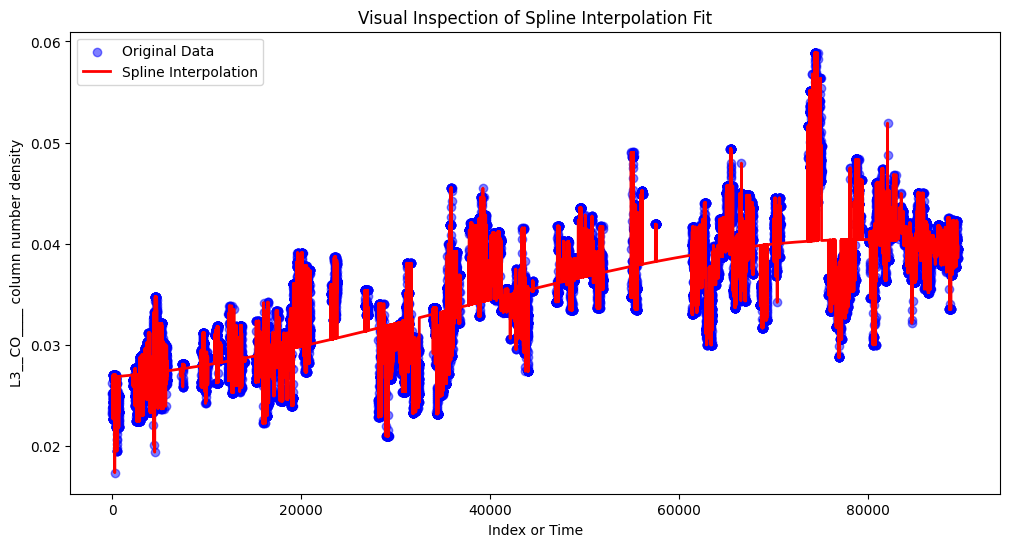

In [34]:

# Load your dataset
file_path = file_path_L3_CSV

data = pd.read_csv(file_path)

# Assuming 'tropospheric_NO2_column_number_density' has NaN values you've interpolated
# Perform spline interpolation (for demonstration, using cubic spline, order=3)
data['interpolated'] = data['CO_column_number_density'].interpolate(method='spline', order=3)

# Plotting
plt.figure(figsize=(12, 6))

# Plot original data points
plt.scatter(data.index, data['CO_column_number_density'], color='blue', label='Original Data', alpha=0.5)

# Plot interpolated data
plt.plot(data.index, data['interpolated'], color='red', label='Spline Interpolation', linewidth=2)

plt.title('Visual Inspection of Spline Interpolation Fit')
plt.xlabel('Index or Time')
plt.ylabel(f'{pollutant_for_L3} column number density')
plt.legend()
plt.show()

**Tips for Visual Inspection:**

**Identify Overfitting:** Look for sections where the red spline line (interpolated data) follows the blue points (original data) too closely, including the noise. This might indicate overfitting.

**Identify Underfitting:** Notice areas where the spline does not capture significant trends or patterns in the data, suggesting underfitting.

**Adjust Order:** If you observe overfitting or underfitting, consider adjusting the order of the spline interpolation. Lower orders reduce complexity (less likely to overfit) but might miss capturing the data trend accurately (underfit). Higher orders can capture more complex patterns but risk overfitting to noise.

This process is iterative—adjust the spline order and inspect the fit visually until you find the balance that best represents your data's underlying trend.